<a href="https://colab.research.google.com/github/CodeMonkey01/DataMiningI/blob/main/ANN_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANN with BERT
In this notebook I tried to solve the classification model with an ANN based on pretrained BERT layers.

## TODO:
- [ ] Stemming
- [ ] Remove Stop Words

## Results
### Result 1
No Stemming and no other major preprocessing results in a score of:

accuracy: 0.9146 - precision: 0.9048 - recall: 0.9263

Training time: 5 * 15 Minutes

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd '/content/drive/MyDrive/'

    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('Not connected to a GPU')
    else:
      print(gpu_info)
except ImportError as e:
    pass

Mounted at /content/drive/
/content/drive/MyDrive
Sat May 14 06:27:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                      

In [34]:
!pip install tensorflow_text
!pip install tensorflow_hub

In [35]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

In [39]:
df = pd.read_csv('/content/drive/MyDrive/Data Mining/dataset.txt')
df.describe()

,text,humor
count,200000,200000
unique,200000,2
top,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
freq,1,100000


# Check for imbalance
The dataset is equally balanced. Therefore, we do not need to rebalance the dataset.

In [44]:
df["humor"].value_counts()

False    100000
True     100000
Name: humor, dtype: int64

# Preprocessing

In [49]:
# Transform class from Boolean to integer value
df['class']=df['humor'].apply(lambda x: 1 if x==True else 0)

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'],df['class'], stratify=df['class'])

# BERT

In [52]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [54]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

## Test embedding
Test word embedding from pretrained BERT model with a real sentence from dataset.

In [58]:
test_sentence = df["text"][100]
print("Test sentence:")
print(test_sentence)
print("Test sentence (word embedding):")
print(get_sentence_embeding([test_sentence]))

Test sentence:
The killer cookie-selling tactics of history's most brilliant girl scouts
Test sentence (word embedding):
tf.Tensor(
[[-0.8383674  -0.5698111  -0.93893224  0.7274852   0.7521046  -0.21280268
   0.662314    0.29903945 -0.80004877 -0.9999303  -0.7598443   0.9762059
   0.9827676   0.60256517  0.89031804 -0.6077464  -0.40622038 -0.49395287
   0.33386633 -0.04131969  0.8039414   0.99999344 -0.3836854   0.43390495
   0.6210272   0.99278605 -0.8362436   0.91170084  0.93795663  0.7941823
  -0.43672553  0.47321633 -0.9925877  -0.26447856 -0.9361383  -0.9939919
   0.53679025 -0.57231116  0.2705292   0.02515196 -0.85115147  0.2810659
   0.9999263   0.32382467  0.43440333 -0.21971542 -1.          0.33585405
  -0.81916404  0.94695175  0.8892858   0.9612853   0.2559307   0.61210674
   0.38046634 -0.6135495   0.11692104  0.2888212  -0.3547126  -0.6275435
  -0.6321413   0.57837707 -0.9253761  -0.7939989   0.9640587   0.79581815
  -0.3925013  -0.39623934 -0.19945098 -0.08280874  0.738007

# Build model

In [59]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [60]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [61]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [63]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
4688/4688 [==============================] - 992s 212ms/step - loss: 0.2164 - accuracy: 0.9171 - precision: 0.9092 - recall: 0.9266
Epoch 2/5
4688/4688 [==============================] - 990s 211ms/step - loss: 0.2075 - accuracy: 0.9203 - precision: 0.9131 - recall: 0.9290
Epoch 3/5
4688/4688 [==============================] - 989s 211ms/step - loss: 0.2031 - accuracy: 0.9217 - precision: 0.9154 - recall: 0.9293
Epoch 4/5
4688/4688 [==============================] - 985s 210ms/step - loss: 0.2033 - accuracy: 0.9212 - precision: 0.9148 - recall: 0.9289
Epoch 5/5
4688/4688 [==============================] - 984s 210ms/step - loss: 0.2007 - accuracy: 0.9233 - precision: 0.9166 - recall: 0.9314


In [64]:
model.evaluate(X_test, y_test)

1563/1563 [==============================] - 332s 212ms/step - loss: 0.1691 - accuracy: 0.9363 - precision: 0.9402 - recall: 0.9319


[0.16913430392742157,
 0.9363200068473816,
 0.9402292370796204,
 0.931879997253418]

In [65]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [66]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 0, ..., 1, 1, 1])

In [67]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[23519,  1481],
       [ 1703, 23297]])

Text(33.0, 0.5, 'Truth')

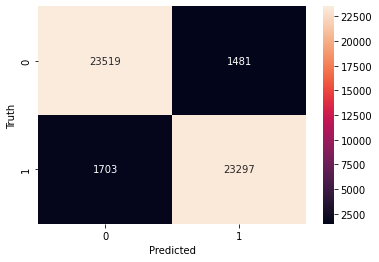

In [68]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [69]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94     25000
           1       0.94      0.93      0.94     25000

    accuracy                           0.94     50000
   macro avg       0.94      0.94      0.94     50000
weighted avg       0.94      0.94      0.94     50000



# Own test

In [70]:
jokes = [
    'What’s the best thing about Switzerland? I don’t know, but the flag is a big plus.',
    'I study Business Informatics at the University of Mannheim!',
    'I invented a new word! Plagiarism!',
    'Did you hear about the mathematician who’s afraid of negative numbers? He’ll stop at nothing to avoid them.',
    'My name is Elias.'
]
model.predict(jokes)

array([[0.90076846],
       [0.8320958 ],
       [0.78852123],
       [0.93628854],
       [0.9870832 ]], dtype=float32)